## Doodle Classifier

## QuickDraw Data

If machine learning is rocket science then data is your fuel! So before
doing anything we will have a close look at the data available and spend
some time bringing it into the "right" form (i.e.
[tf.train.Example](https://www.tensorflow.org/api_docs/python/tf/train/Example)).

That's why we start by spending quite a lot of time on this notebook, downloading
the data, understanding it, and transforming it into the right format for
Tensorflow.

The data used in this workshop is taken from Google's quickdraw (click on
the images to see loads of examples):

https://quickdraw.withgoogle.com/data

We will download the data below.

In [1]:
import base64, collections, io, itertools, functools, json, os, random, re, textwrap, time, urllib, xml

import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
from tensorflow.keras.layers import *
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageOps
from IPython import display
from pathlib import Path
from quickdraw import QuickDrawDataGroup,QuickDrawData

In [2]:
image_size = (28, 28)
drawing_names = ['cat', 'mushroom', 'house', 'windmill', 'hamburger', 'fish', 'calculator', 'banana', 'house plant', 'headphones']  
model_name = 'combined_v2_28'

In [3]:
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)
        
for label in drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True)

loading cat drawings
load complete
loading mushroom drawings
load complete
loading house drawings
load complete
loading windmill drawings
load complete
loading hamburger drawings
load complete
loading fish drawings
load complete
loading calculator drawings
load complete
loading banana drawings
load complete
loading house plant drawings
load complete
loading headphones drawings
load complete


## Training sets

In [4]:
batch_size = 32
dataset_dir = Path("dataset")

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=20,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=20,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 12000 files belonging to 10 classes.
Using 9600 files for training.


2022-05-24 13:08:06.371150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 12000 files belonging to 10 classes.
Using 2400 files for validation.


## Example data

loading cat drawings
load complete


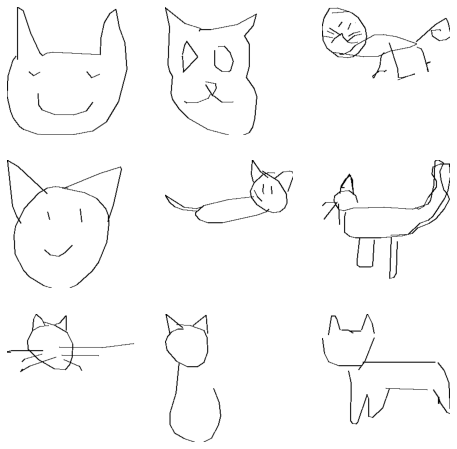

loading mushroom drawings
load complete


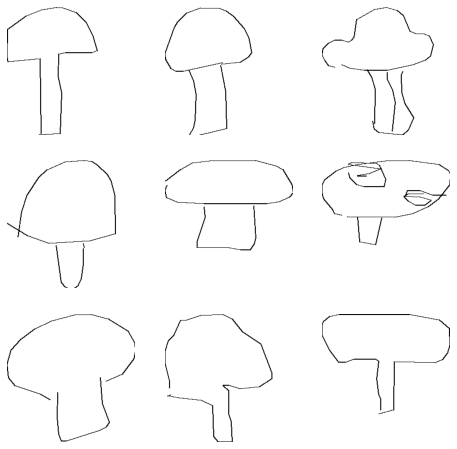

loading house drawings
load complete


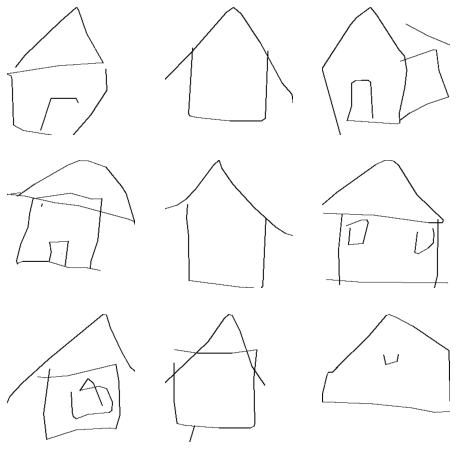

loading windmill drawings
load complete


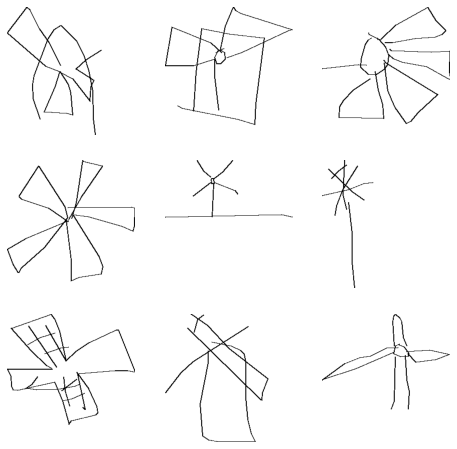

loading hamburger drawings
load complete


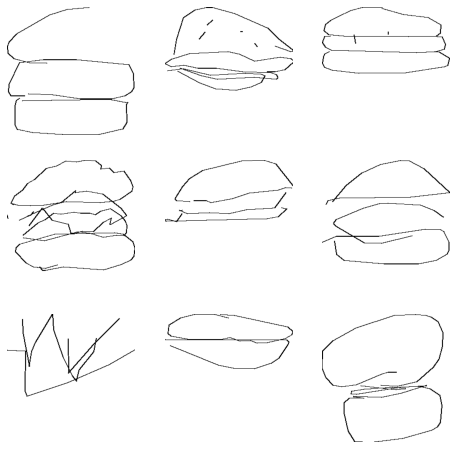

loading fish drawings
load complete


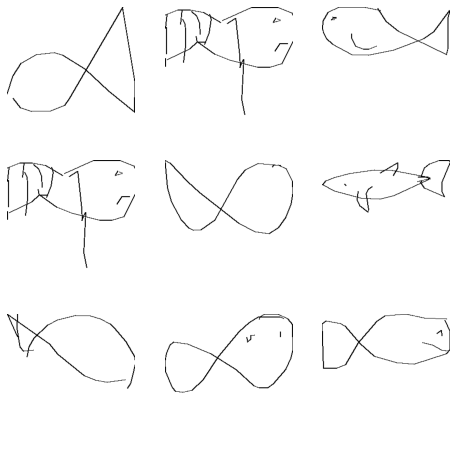

loading calculator drawings
load complete


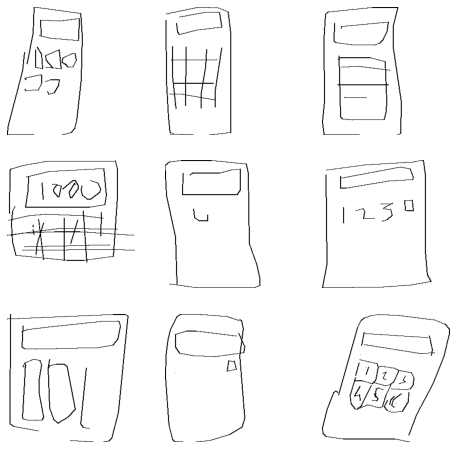

loading banana drawings
load complete


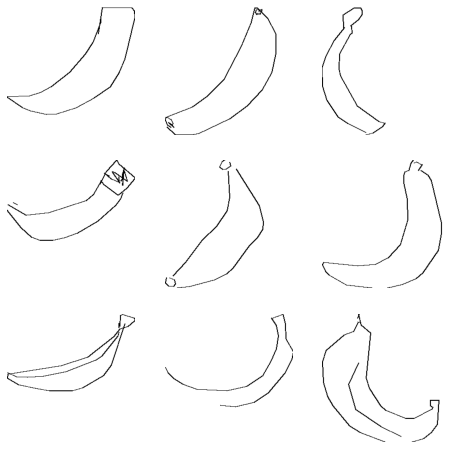

loading house plant drawings
load complete


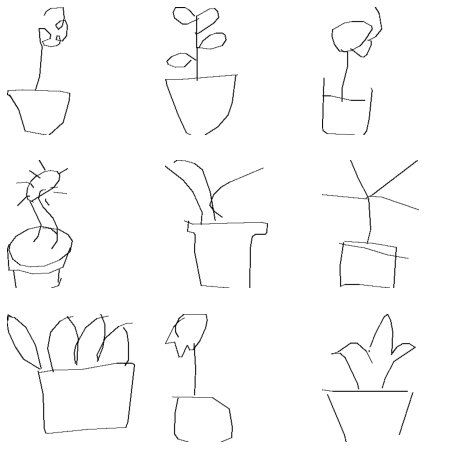

loading headphones drawings
load complete


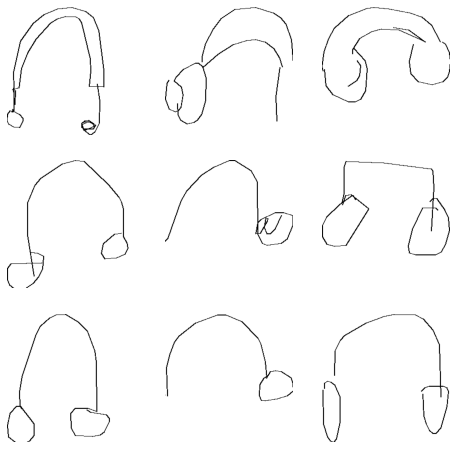

In [5]:
def drawDoodles(labels):
    for label in labels:
        qd = QuickDrawData()
        plt.figure(figsize=(8, 8))
        for j in range(9):
            plt.subplot(3, 3, j + 1)
            data = qd.get_drawing(label)
            plt.imshow(data.image)
            plt.axis("off")
        plt.show()

drawDoodles(drawing_names)

## Model

In [6]:
n_classes = len(drawing_names)
input_shape = image_size + (1,)

model = tf.keras.models.Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),
    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    
    Dense(700, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation="relu"),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2, clipnorm=1.),
            metrics=['accuracy', 'top_k_categorical_accuracy'])

# model = tf.keras.models.Sequential([
#     Rescaling(1. / 255, input_shape=input_shape),
#     tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.GRU(128, return_sequences=True),
#     tf.keras.layers.GRU(128),
#     tf.keras.layers.Dense(n_classes, activation='softmax')     
# ])
# model.compile(loss='sparse_categorical_crossentropy',
#             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.),
#             metrics=['accuracy', 'top_k_categorical_accuracy'])

In [7]:
tf.keras.backend.clear_session()
epochs = 20
checkpoint_path = "training_1/cp.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_ds, 
          epochs=epochs, 
          validation_data=val_ds, 
          callbacks=[model_checkpoint_callback])

Epoch 1/20
300/300 [==============================] - 19s 58ms/step - loss: 1.2735 - accuracy: 0.7497 - top_k_categorical_accuracy: 0.4647 - val_loss: 1.5861 - val_accuracy: 0.5854 - val_top_k_categorical_accuracy: 0.8096
Epoch 2/20
300/300 [==============================] - 19s 62ms/step - loss: 0.4993 - accuracy: 0.8732 - top_k_categorical_accuracy: 0.5318 - val_loss: 0.3040 - val_accuracy: 0.9200 - val_top_k_categorical_accuracy: 0.5583
Epoch 3/20
300/300 [==============================] - 17s 58ms/step - loss: 0.3568 - accuracy: 0.9053 - top_k_categorical_accuracy: 0.3906 - val_loss: 0.2894 - val_accuracy: 0.9229 - val_top_k_categorical_accuracy: 0.3404
Epoch 4/20
300/300 [==============================] - 24s 79ms/step - loss: 0.2932 - accuracy: 0.9239 - top_k_categorical_accuracy: 0.3703 - val_loss: 0.3161 - val_accuracy: 0.9317 - val_top_k_categorical_accuracy: 0.4079
Epoch 5/20
300/300 [==============================] - 19s 64ms/step - loss: 0.2455 - accuracy: 0.9399 - top_k_ca

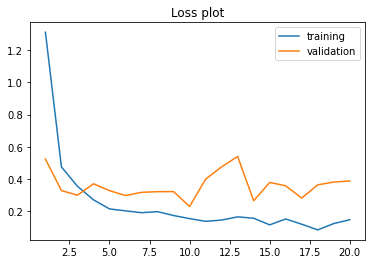

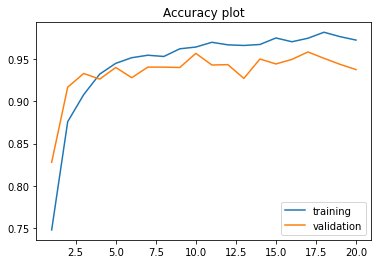

In [8]:
def plotStats():    
    plt.figure()
    plt.plot(range(1,epochs+1),history.history['loss'], label='training')
    plt.plot(range(1,epochs+1),history.history['val_loss'], label='validation')
    plt.title('Loss plot')
    plt.legend()
    plt.show()

    plt.figure
    plt.plot(range(1,epochs+1),history.history['accuracy'], label='training')
    plt.plot(range(1,epochs+1),history.history['val_accuracy'], label='validation')
    plt.title('Accuracy plot')
    plt.legend()
    plt.show()

plotStats()

## Save model

In [8]:
model.load_weights(checkpoint_path)
model.save('saved_model/'+model_name)

INFO:tensorflow:Assets written to: saved_model/combined_v2_28/assets


INFO:tensorflow:Assets written to: saved_model/combined_v2_28/assets


In [9]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/'+model_name) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('tflite_model/'+model_name+'.tflite', 'wb') as f:
  f.write(tflite_model)

2022-05-24 15:32:33.832854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-05-24 15:32:33.833097: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-05-24 15:32:33.871300: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: saved_model/combined_v2_28
2022-05-24 15:32:33.888093: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-05-24 15:32:33.888425: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: saved_model/combined_v2_28
2022-05-24 15:32:33.919406: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-05-24 15:32:33.940033: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-24 15:32:34.436604: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: save

## Load model

In [2]:
model = tf.keras.models.load_model('saved_model/combined_v2_28')

2022-05-31 11:41:29.185701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Predict new image

In [60]:
# lists = tf.reshape(tf.convert_to_tensor(doei),(-1,) + image_size + (1,)).tolist()
lists = np.reshape(doei,(-1,) + image_size + (1,)).tolist()

json_str = json.dumps(lists)

In [61]:
json_str

'[[[[255], [255], [244], [220], [213], [227], [228], [228], [228], [219], [215], [237], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255]], [[255], [210], [212], [240], [255], [255], [255], [255], [255], [255], [246], [224], [218], [226], [236], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [254], [255], [255]], [[199], [216], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [252], [229], [187], [185], [224], [251], [255], [255], [255], [255], [255], [255], [188], [240], [255], [255]], [[203], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [238], [221], [216], [222], [244], [255], [255], [255], [208], [201], [211], [255], [255]], [[230], [255], [255], [248], [237], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [255], [240], [219], [217], [239], [225], [201], [255], [207], [242], [255]], [[208],

loading fish drawings
load complete
1/1 [==============================] - 0s 235ms/step
This image most likely belongs to fish with a 69.36 percent confidence.


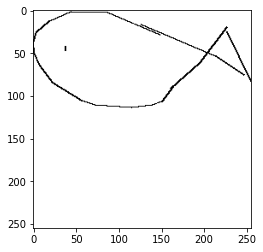

In [54]:
qd = QuickDrawData()
hoi = qd.get_drawing('fish').image
plt.imshow(hoi)
hoi = ImageOps.grayscale(hoi)
doei = np.array(hoi.resize(image_size))
class_names = train_ds.class_names
predictions = model.predict(tf.reshape(tf.convert_to_tensor(doei),(-1,) + image_size + (1,)))
score = tf.nn.tanh(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

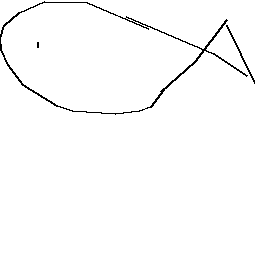

In [63]:
hoi

In [34]:
class_names

['banana',
 'calculator',
 'cat',
 'fish',
 'hamburger',
 'headphones',
 'house',
 'house plant',
 'mushroom',
 'windmill']

### Draw image

In [80]:
%gui tk

In [1]:
from tkinter import *
b1 = "up"
xold, yold = None, None

def main():
    root = Tk()
    root.title("Canvas Draw")
    drawing_area = Canvas(root,width=600,height=600)
    drawing_area.pack()
    drawing_area.bind("<Motion>", motion)
    drawing_area.bind("<ButtonPress-1>", b1down)
    drawing_area.bind("<ButtonRelease-1>", b1up)
    button4=Button(root,fg="green",text="Save",command=lambda:getter(drawing_area))
    button4.pack(side=RIGHT)
    button4=Button(root,fg="green",text="Clear",command=lambda:delete(drawing_area))
    button4.pack(side=LEFT)
    def delete(widget):
        widget.delete("all")
    def getter(widget):
        from PIL import ImageGrab
        x=root.winfo_rootx()+widget.winfo_x()
        y=root.winfo_rooty()+widget.winfo_y()
        x1=x+widget.winfo_width()
        y1=y+widget.winfo_height()
        import datetime
        now = datetime.datetime.now()
        ImageGrab.grab().crop((x,y,x1,y1)).save(str(now)+".png")
    root.mainloop()
def b1down(event):
    global b1
    b1 = "down"
def b1up(event):
    global b1, xold, yold
    b1 = "up"
    xold = None
    yold = None

def motion(event):
    if b1 == "down":
        global xold, yold
        if xold is not None and yold is not None:
            event.widget.create_line(xold,yold,event.x,event.y,smooth=TRUE)
        xold = event.x
        yold = event.y

main()

In [56]:
tf.__version__

'2.9.0'

### Predict new image

In [ ]:
model = tf.keras.models.load_model('saved_model/combined_v2_28')

1/1 [==============================] - 0s 347ms/step
This image most likely belongs to house with a 76.16 percent confidence.


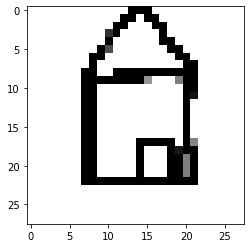

In [5]:
image_size = (28,28)
hoi = Image.open('/Users/bryan/Downloads/house.png')
plt.imshow(hoi)
hoi = ImageOps.grayscale(hoi)
doei = np.array(hoi.resize(image_size))
class_names = ['banana',
  'calculator',
  'cat',
  'fish',
  'hamburger',
  'headphones',
  'house',
  'house plant',
  'mushroom',
  'windmill'];
predictions = model.predict(tf.reshape(tf.convert_to_tensor(doei),(-1,) + image_size + (1,)))
score = tf.nn.tanh(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [15]:
predictions

array([[1.2870535e-19, 8.6058257e-22, 2.1655900e-24, 3.7870332e-19,
        5.0942488e-16, 2.1525506e-18, 1.0000000e+00, 6.2045986e-11,
        6.5267171e-15, 1.3389415e-08]], dtype=float32)